In [1]:
import ztfimg
from ztfimg import catalog, science
import ztfin2p3
from ztfin2p3 import catalog 
import pandas as pd
from PIL import Image
import numpy as np
from scipy import optimize, stats
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from astropy.modeling.models import Moffat2D

In [2]:
import pkg_resources
print(pkg_resources.get_distribution('numpy').version)

1.26.2


# Image selection

In [3]:
# importing image
img = ztfimg.ScienceQuadrant.from_filename("/sps/ztf/data/sci/2020/0924/431759/ztf_20200924431759_000655_zr_c13_o_q3_sciimg.fits")
q1 = img.get_ccd().get_quadrant(1) #selects quadrant 1 
qimg1 = q1.get_data() #converted to numpy array

# importing data into a pandas.dataframe
qimg1_catalog = ztfin2p3.catalog.get_img_refcatalog(q1, which="gaia_dr2") # selects the data corresponding to the quadrant in the gaia_dr2 catalog
qimg1_catalog['isolated'] = ztfimg.catalog.get_isolated(qimg1_catalog, seplimit=20) #select stars that are 15 arcsec apart and add a Boolean column
qimg_catalog_isolated = qimg1_catalog.loc[qimg1_catalog['isolated'] == True] # we keep only isolated stars (whose Boolean is True)

# magnitude selection
mag_inf = qimg_catalog_isolated.phot_g_mean_mag > 14 #selects magnitudes above 14
mag_sup = qimg_catalog_isolated.phot_g_mean_mag < 18 #selects magnitudes below 18
qimg_catalog_isolated_mag = qimg_catalog_isolated.loc[mag_inf & mag_sup] #application of the mask on magnitudes
qimg_catalog_isolated_mag = qimg_catalog_isolated_mag.drop('isolated', axis=1) #supression of isolated column

# location selection
mag_bord_left = qimg_catalog_isolated_mag.x > 15 # removes stars on the left edge of 15 pixels
mag_bord_right = qimg_catalog_isolated_mag.x < (q1.shape[0]-15) # removes stars on the right edge of 15 pixels
mag_bord_top = qimg_catalog_isolated_mag.y > 15 # removes the stars on the top edge by 15 pixels
mag_bord_bottom = qimg_catalog_isolated_mag.y < (q1.shape[1]-15) # removes stars on the bottom edge of 15 pixels
mag_bord_combined = np.logical_and.reduce((mag_bord_left, mag_bord_right, mag_bord_top, mag_bord_bottom)) #edge selection
qimg_catalog_isolated_mag_bord = qimg_catalog_isolated_mag[mag_bord_combined] #application of edge mask
#qimg_catalog_isolated_mag_bord.to_csv('data_ztf.csv', index=False) #to save the dataframe in csv format
qimg_catalog_isolated_mag_bord

,id,coord_ra,coord_dec,phot_g_mean_flux,phot_bp_mean_flux,phot_rp_mean_flux,phot_g_mean_fluxErr,phot_bp_mean_fluxErr,phot_rp_mean_fluxErr,coord_raErr,...,ra,dec,phot_g_mean_mag,phot_bp_mean_mag,phot_rp_mean_mag,phot_g_mean_magErr,phot_bp_mean_magErr,phot_rp_mean_magErr,x,y
3292,220210914664501376,1.026161,0.637330,3.411760e+05,2.496884e+05,4.863944e+05,333.605022,4307.633356,1871.193552,0.002145,...,58.794687,36.516333,17.567620,17.906570,17.182594,0.001062,0.018731,0.004177,665.035175,1267.744563
3314,220210949024241920,1.025702,0.637414,2.846405e+05,1.552300e+05,4.988820e+05,263.706599,2006.851979,3996.709121,0.001880,...,58.768417,36.521120,17.764324,18.422627,17.155071,0.001006,0.014037,0.008698,589.417449,1282.097111
3343,220214655577103232,1.022990,0.637796,6.637216e+05,4.199027e+05,1.086072e+06,553.114736,1744.992099,2613.982357,0.001542,...,58.612995,36.543040,16.845101,17.342194,16.310420,0.000905,0.004512,0.002613,142.980478,1344.672348
3494,220216407923781760,1.023645,0.639737,3.310731e+05,2.083656e+05,5.224247e+05,297.967950,1487.596690,3983.500840,0.001617,...,58.650511,36.654212,17.600256,18.103001,17.105006,0.000977,0.007751,0.008279,236.507139,1743.317737
3524,220213216767321088,1.026577,0.638661,7.455134e+05,4.821637e+05,1.142259e+06,524.353589,3058.071864,5102.794374,0.001253,...,58.818547,36.592557,16.718927,17.192079,16.255654,0.000764,0.006886,0.004850,723.407453,1541.004010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45776,220167793192842368,1.033080,0.634488,4.161678e+06,3.407272e+06,5.055197e+06,1242.641362,5762.443728,7624.821103,0.000454,...,59.191138,36.353509,14.851894,15.069049,14.640720,0.000324,0.001836,0.001638,1820.108284,731.855584
45799,220175077457571712,1.036926,0.636100,1.675470e+06,1.183528e+06,2.416099e+06,681.649828,2936.846731,3462.371170,0.000738,...,59.411462,36.445829,15.839724,16.217119,15.442279,0.000442,0.002694,0.001556,2436.769333,1085.493345
45891,220225586272711168,1.030969,0.639192,6.834436e+05,4.806962e+05,9.924018e+05,407.310306,1946.126256,4175.423717,0.001170,...,59.070190,36.622983,16.813309,17.195389,16.408347,0.000647,0.004396,0.004568,1437.085775,1675.756830
45903,220222596975471872,1.031456,0.639021,6.083751e+05,5.244016e+05,7.197826e+05,425.536839,2348.414058,4584.703300,0.001287,...,59.098059,36.613195,16.939637,17.100906,16.757062,0.000759,0.004862,0.006916,1517.911040,1644.046424


# Functions

The Moffat distribution is:
$$
f(x, y, \alpha, \beta) =  A \left[1 + \left(\frac{(x-x_0)^2 + (y-y_0)^2}{\gamma^2}\right)\right]^{-\alpha}
$$
where
$$
A = \frac{\alpha - 1}{\pi \gamma^2}
$$

In [4]:
def get_model_moffat(A, x0, y0, gamma, alpha, b, X, Y):
    """
    Returns the normalized Moffat function.

    Parameters:
    -----------
    x0, y0 : float
        Coordinates of image center (where star is located).
    gamma : float
        Width parameter
    beta : float
        Shape parameter
    A : float
        Amplitude
    b : float
        background
    X, Y: arraylike
        Grid points to evaluate the model.
    
    Returns :
    ---------
    model : arraylike
        normalized Moffat function    
    """
    model_moffat = Moffat2D(amplitude=A, x_0=x0, y_0=y0, gamma=gamma, alpha=alpha)
    model = A*model_moffat(X, Y) + b
    return model

def get_logprior(params):
    """
    Returns the probability to have sigmax and sigma y
    
    Parameters:
    -----------
    params: list
        selected model parameters
    
    Returns:
    -------
    logprior: float
        sum of the two sigma probabilities
    """
    A, x0, y0, gamma, alpha, b = params
    logprior_alpha = stats.norm.logpdf(gamma, loc=1, scale=0.5)
    logprior_beta = stats.norm.logpdf(alpha, loc=1, scale=0.5)
    return logprior_alpha + logprior_beta

def get_likelihood(params, stamp, X, Y):
    """
    Computes the Chi squared from the selected model
    
    Parameters:
    ----------
    params: list
        Selected model parameters.
    stamp: arraylike
        Image of one star.
    X, Y: arraylike
        Grid points to evaluate the model.
    
    Returns:
    --------
    summ: float
        Chi squared.
    """
    model = get_model_moffat(*params, X, Y).ravel()
    summ = np.sum((model - stamp)**2)

    return summ


def get_logprob(params, stamp, X, Y):
    """ 
    Computes the sum of the sigma probabilities and the chi squared
    
    Parameters:
    -----------
    params: list
        selected model parameters
    stamp: arraylike
        image of one star
    
    Returns:
    logprob: float
        sum of the sigma probabilities and the chi squared
    """
    logprior = -1* get_logprior(params) # to minimize
    likelihood = get_likelihood(params, stamp, X, Y)
    logprob = logprior + likelihood
    return logprob

def fits(params, data, X, Y):
    """
    Minimizes the parameters of a chosen model
    
    Parameters:
    -----------
    params: list
        Selected model parameters.
    data: arraylike
        Data on which parameters are fitted.
    X, Y: arraylike
        Grid points to evaluate the model.
    
    Returns:
    --------
    out: list
        Fitted parameters.
    """
    out = optimize.minimize(get_logprob, params, args=(data, X, Y), method="BFGS")
    return out

# Fit for 1 star

chi squared: 0.000099
optimized parameters A=0.12203, x0=0.48614, y0=0.27890, gamma=0.99994, alpha=1.00007, b=0.00280
optimized parameters errors A_err=1.9172, x0_err=32.9318, y0_err= 18.1640, gamma_err=0.504, alpha_err=0.499, b_err=0.049
CPU times: user 516 ms, sys: 18.2 ms, total: 534 ms
Wall time: 542 ms


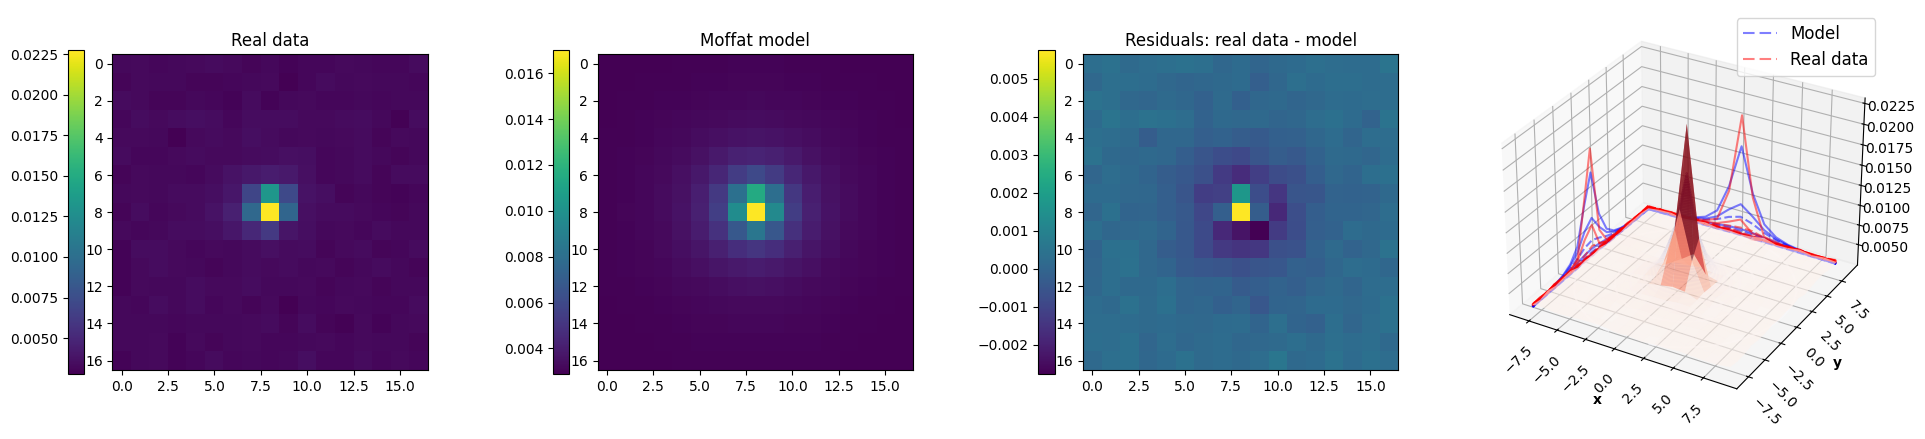

In [5]:
%%time

# create an image centered on a star
df = qimg_catalog_isolated_mag_bord.loc[3292]
x = df.x
y = df.y
x0 = int(round(x))
y0 = int(round(y))
size = 17
left = x0 - (size // 2)
top = y0 - (size // 2)
right = left + size
bottom = top + size
stamp = qimg1[top:bottom, left:right]

X = np.linspace(left, right, size) - x0
Y = np.linspace(top, bottom, size) - y0
X, Y = np.meshgrid(X, Y)
pos = np.vstack((X.ravel(), Y.ravel()))

# fitting a moffat model to the data
params_init = (1, 0, 0, 1, 1, 0)  # initial parameters for the moffat model : A, x0, y0, gamma, alpha, b
to_fit = stamp/stamp.sum()
fout = fits(params_init, to_fit.ravel(), X, Y)
model = get_model_moffat(*fout.x, X, Y).reshape(size,size)
residuals = (to_fit - model).reshape(size, size)

hessian_inv = fout.hess_inv
errors = np.sqrt(np.diag(hessian_inv))

print("chi squared:", f"{get_likelihood(fout.x, to_fit.ravel(), X, Y):.6f}")
print("optimized parameters", f"A={fout.x[0]:.5f}, x0={fout.x[1]:.5f}, y0={fout.x[2]:.5f}, gamma={fout.x[3]:.5f}, alpha={fout.x[4]:.5f}, b={fout.x[5]:.5f}") 
print("optimized parameters errors", f"A_err={errors[0]:.4f}, x0_err={errors[1]:.4f}, y0_err= {errors[2]:.4f}, gamma_err={errors[3]:.3f}, alpha_err={errors[4]:.3f}, b_err={errors[5]:.3f}")

# Data and results display
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (24, 6))
im1 = ax1.imshow(to_fit)
ax1.set_title('Real data')
plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)
im2 = ax2.imshow(model.reshape(17,17))
ax2.set_title('Moffat model')
plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)
im3 = ax3.imshow(residuals)
ax3.set_title('Residuals: real data - model')
plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)

fig = plt.gcf()
spec = ax4.get_subplotspec()
fig.delaxes(ax4)
ax4_3d = fig.add_subplot(spec, projection='3d')
ax4_3d.plot_surface(X, Y, to_fit, cmap='Reds', alpha=0.6, label='real data')
ax4_3d.contour3D(X, Y, model.reshape(17,17), levels=50, cmap='Purples', alpha=0.6)
ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
ax4_3d.xaxis.set_tick_params(rotation=45)
ax4_3d.yaxis.set_tick_params(rotation=-45)
c1 = ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
c2 = ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
h1, _ = c1.legend_elements()
h2, _ = c2.legend_elements()
ax4_3d.legend([h1[0], h2[0]], ['Model', 'Real data'], fontsize=12)

In [6]:
noise = fout.x[0] / errors[0]
print(noise)

0.0636512816599125


# Fit with for loop

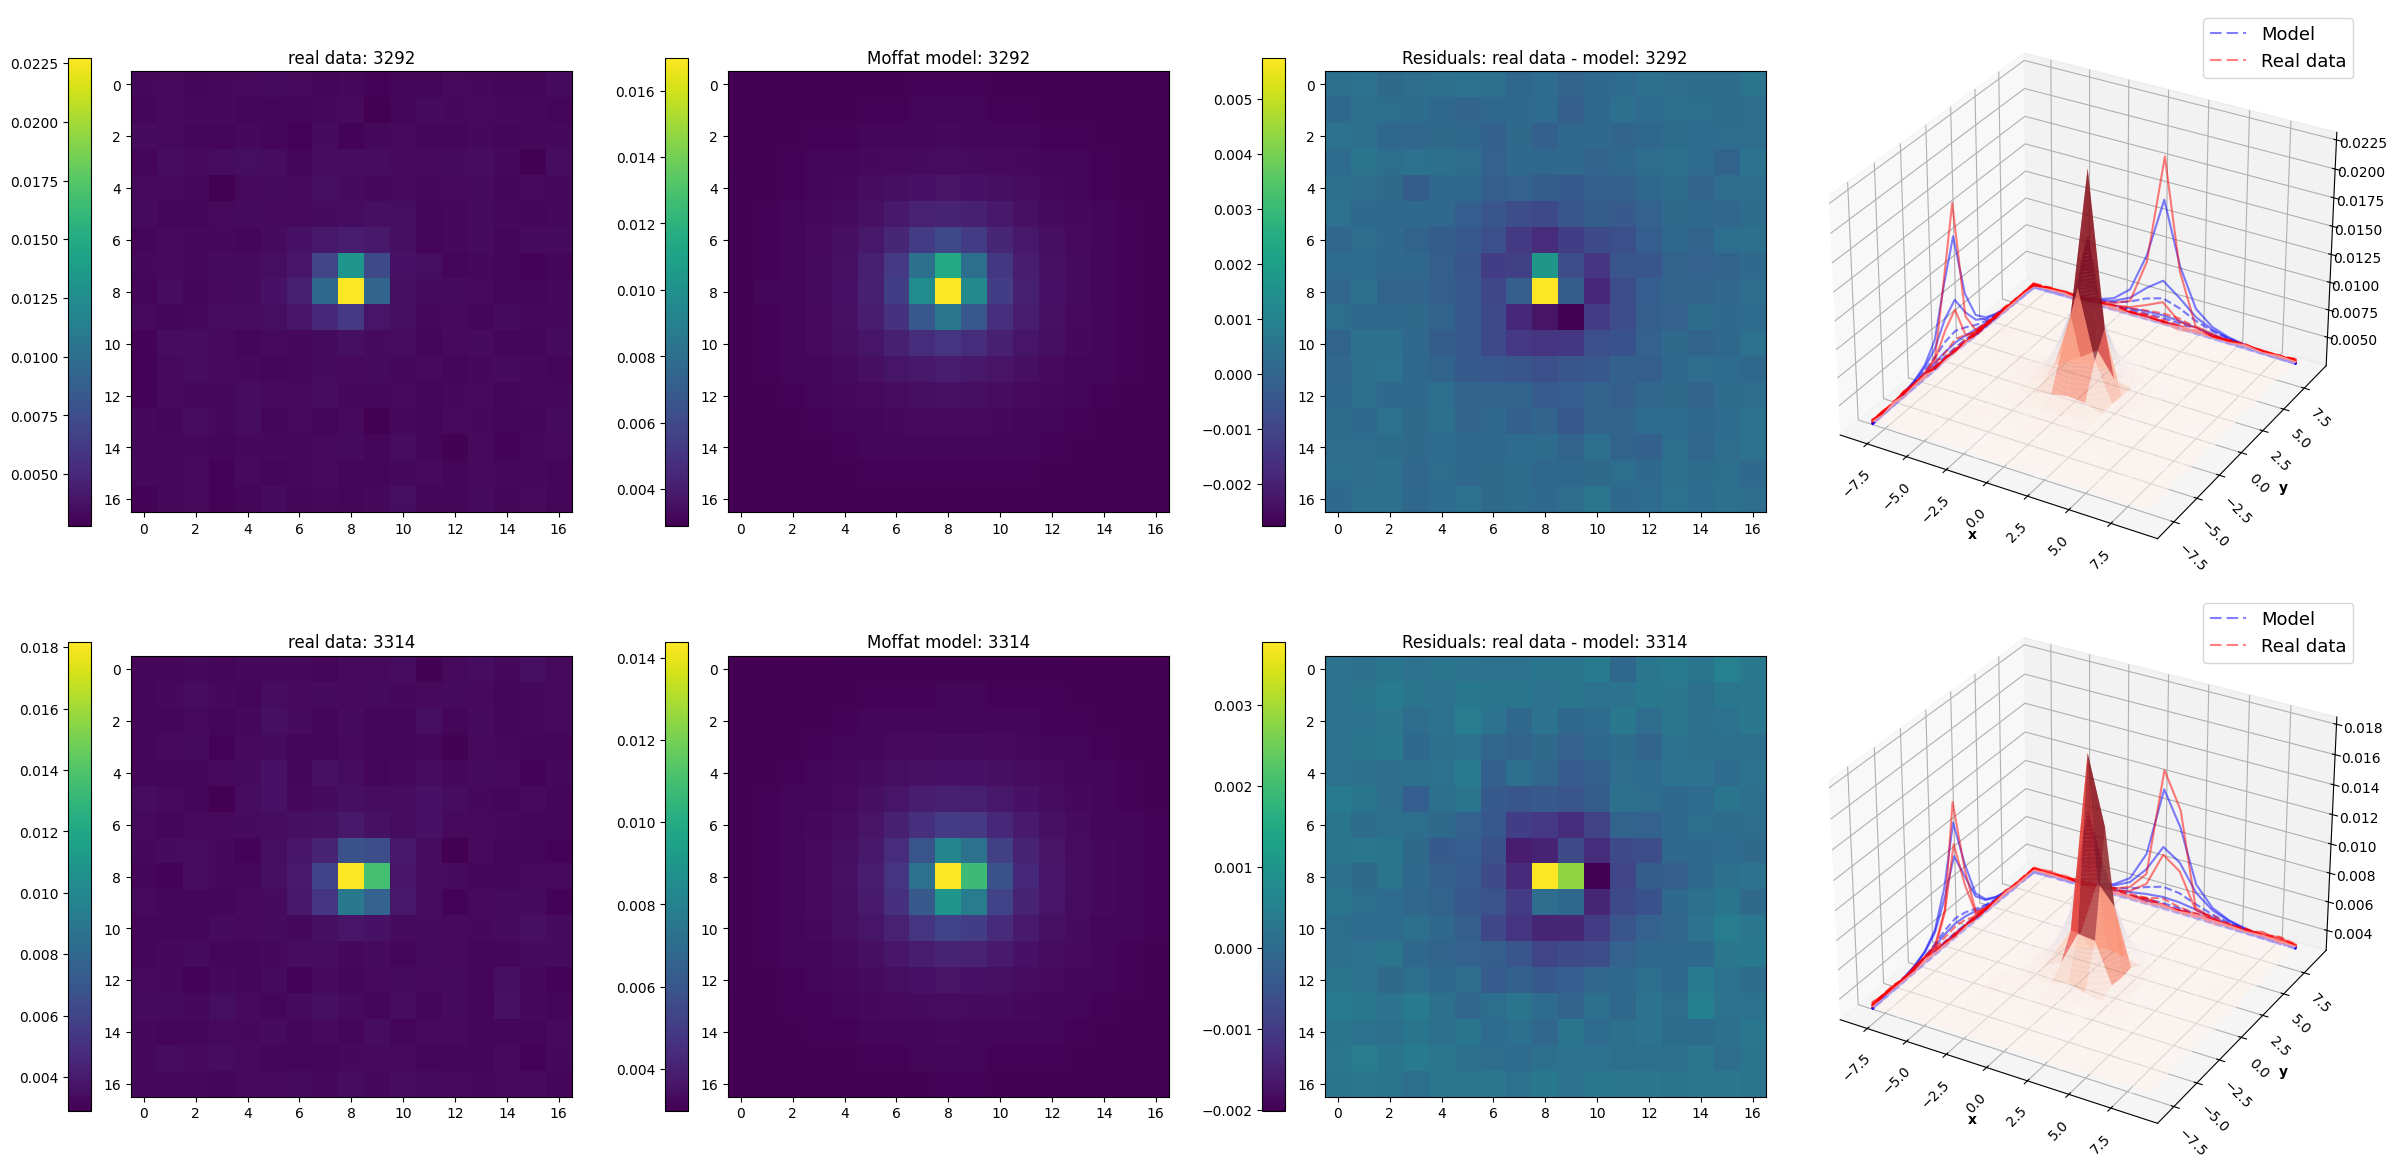

CPU times: user 3.18 s, sys: 83 ms, total: 3.26 s
Wall time: 3.26 s


In [7]:
%%time

total_images = 2 # number of data items selected in the dataframe
end = qimg_catalog_isolated_mag_bord.head(total_images)
num_cols = 4
num_rows = total_images 
fig_height = num_rows * 6
fig_width = num_cols * 6
fig, axes = plt.subplots(total_images, num_cols, figsize = (fig_width, fig_height))
size = 17


# noises = []

for i, (index, row) in enumerate(end.iterrows()):
    
    # create an image centered on a star
    x0 = int(round(row['x']))
    y0 = int(round(row['y']))
    left = x0- (size // 2)
    top = y0 - (size // 2)
    right = left + size
    bottom = top + size
    X = np.linspace(left, right, size) - x0
    Y = np.linspace(top, bottom, size) - y0
    X, Y = np.meshgrid(X, Y)
    pos = np.vstack((X.ravel(), Y.ravel()))
    stamp = qimg1[top:bottom, left:right]
    
    # fitting a gaussian model to the data
    to_fit = stamp/stamp.sum()
    fout = fits(params_init, to_fit.ravel(), X, Y)
    #print("param opt: A, x0, y0, gamma, alpha, b:", fout.x) 
    model = get_model_moffat(*fout.x, X, Y).reshape(size,size)
    residuals = (to_fit - model).reshape(size, size)

    hessian_inv = fout.hess_inv
    errors = np.sqrt(np.diag(hessian_inv))
    #print("errors on optimized parameters", errors)

#     noise = fout.x[0] / errors[0]
#     noises.append(noise)

# plt.scatter(end['phot_g_mean_mag'], noises)
# plt.xlabel('magnitude')
# plt.ylabel('A/ err(A)')
    
    # Data and results display
    ax1 = axes[i, 0]
    im1 = ax1.imshow(to_fit)
    ax1.set_title(f'real data: {index}')
    plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)
    ax2 = axes[i, 1]
    im2 = ax2.imshow(model)
    ax2.set_title(f'Moffat model: {index}')
    # ax2.text(0.98, 0.16, f"chi squared={get_likelihood(fout.x, to_fit.ravel(), X, Y):.6f}",
    #         color = 'white', fontsize=13, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.10, f"A={fout.x[0]:.5f}, x0={fout.x[1]:.5f}, y0= {fout.x[2]:.5f}", 
    #          color = 'white', fontsize=13, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.04, f"gamma={fout.x[3]:.5f}, alpha={fout.x[4]:.5f}, b={fout.x[5]:.5f}",
    #          color = 'white', fontsize=13, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)
    ax3 = axes[i, 2]
    im3 = ax3.imshow(residuals)
    ax3.set_title(f'Residuals: real data - model: {index}')
    # ax3.text(0.98, 0.10, f"A_ERR={errors[0]:.4f}, x0_ERR={errors[1]:.4f}, y0_ERR= {errors[2]:.4f}", 
    #          color = 'white', fontsize=11, horizontalalignment='right', verticalalignment='bottom', transform=ax3.transAxes)
    # ax3.text(0.98, 0.04, f"gamma_ERR={errors[3]:.3f}, alpha_ERR={errors[4]:.3f}, b_ERR={errors[5]:.3f}",
    #          color = 'white', fontsize=11, horizontalalignment='right', verticalalignment='bottom', transform=ax3.transAxes)
    plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.8, pad=0.07)

    ax4 = axes[i, 3]
    fig = plt.gcf()
    spec = ax4.get_subplotspec()
    fig.delaxes(ax4)
    ax4_3d = fig.add_subplot(spec, projection='3d')
    ax4_3d.plot_surface(X, Y, to_fit, cmap='Reds', alpha=0.6, label='real data')
    ax4_3d.contour3D(X, Y, model.reshape(17,17), levels=50, cmap='Purples', alpha=0.6)
    ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
    ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
    ax4_3d.xaxis.set_tick_params(rotation=45)
    ax4_3d.yaxis.set_tick_params(rotation=-45)
    c1 = ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
    c2 = ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
    ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
    ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
    h1, _ = c1.legend_elements()
    h2, _ = c2.legend_elements()
    ax4_3d.legend([h1[0], h2[0]], ['Model', 'Real data'], fontsize=13)
    
plt.tight_layout()
plt.show()

## Fit with custom_function

In [8]:
def plot_images(to_fit, model, residuals):
    """ 
    display function 
    
    Parameters:
    -----------
    to_fit: function
        model optimization
    model: arraylike
        optimized model
    residuals: arraylike
        residuals from real data minus optimized model
    """
    
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (20,5))
    im1 = ax1.imshow(to_fit)
    ax1.set_title('real data')
    plt.colorbar(im1, ax=ax1, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)
    im2 = ax2.imshow(model.reshape(17,17))
    ax2.set_title('Moffat model')
    # ax2.text(0.98, 0.16, f"chi squared={get_likelihood(fout.x, to_fit.ravel(), X, Y):.6f}",
    #         color = 'white', fontsize=8, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.10, f"A={fout.x[0]:.4f}, x0={fout.x[1]:.4f}, y0= {fout.x[2]:.4f}", 
    #          color = 'white', fontsize=8, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    # ax2.text(0.98, 0.04, f"gamma={fout.x[3]:.4f}, alpha={fout.x[4]:.4f}, b={fout.x[5]:.4f}",
    #          color = 'white', fontsize=8, horizontalalignment='right', verticalalignment='bottom', transform=ax2.transAxes)
    plt.colorbar(im2, ax=ax2, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)
    im3 = ax3.imshow(residuals.reshape(size, size))
    ax3.set_title('Residuals: real data - model')
    plt.colorbar(im3, ax=ax3, location = 'left', orientation = 'vertical', shrink=0.7, pad=0.07)
    fig = plt.gcf()
    spec = ax4.get_subplotspec()
    fig.delaxes(ax4)
    ax4_3d = fig.add_subplot(spec, projection='3d')
    ax4_3d.plot_surface(X, Y, to_fit, cmap='Reds', alpha=0.6, label='real data')
    ax4_3d.contour3D(X, Y, model.reshape(17,17), levels=50, cmap='Purples', alpha=0.6)
    ax4_3d.set_xlabel('x', fontdict=dict(weight='bold'))
    ax4_3d.set_ylabel('y', fontdict=dict(weight='bold'))
    ax4_3d.xaxis.set_tick_params(rotation=45)
    ax4_3d.yaxis.set_tick_params(rotation=-45)
    c1 = ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='blue', alpha=0.5)
    c2 = ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='y', offset=np.max(Y), colors='red', alpha=0.5)
    ax4_3d.contour(X, Y, model.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='blue', alpha=0.5)
    ax4_3d.contour(X, Y, to_fit.reshape(size, size), 8, zdir='x', offset=np.min(X), colors='red', alpha=0.5)
    h1, _ = c1.legend_elements()
    h2, _ = c2.legend_elements()
    ax4_3d.legend([h1[0], h2[0]], ['Model', 'Real data'], fontsize=10)

In [9]:
def custom_function(row):
    """
    function for model fitting for each row of a dataframe
    
    Parameters:
    -----------
    row: pandas
        dataframe row
    
    Returns:
    -------
    fout.x: List
        optimized parameters
    model: arraylike
        optimized model
    residuals: arraylike
        residuals from real data minus optimized model
    """
    
    #create an image centered on a star
    x0 = int(round(row['x']))
    y0 = int(round(row['y']))
    left = x0 - (size // 2)
    top = y0 - (size // 2)
    right = left + size
    bottom = top + size  
    X = np.linspace(left, right, size) - x0
    Y = np.linspace(top, bottom, size) - y0
    X, Y = np.meshgrid(X, Y)
    pos = np.vstack((X.ravel(), Y.ravel()))
    stamp = qimg1[top:bottom, left:right]
    
    # fitting a gaussian model to the data
    to_fit = stamp/stamp.sum()
    fout = fits(params_init, to_fit.ravel(), X, Y)
    #print("param opt: A, x0, y0, gamma, alpha, b:", fout.x) 
    model = get_model_moffat(*fout.x, X, Y).reshape(size,size)
    residuals = (to_fit - model).reshape(size, size)
       
     # Data and results display
    plot_images(to_fit, model, residuals)
    
    return fout.x, model, residuals

CPU times: user 5.33 s, sys: 223 ms, total: 5.55 s
Wall time: 5.56 s


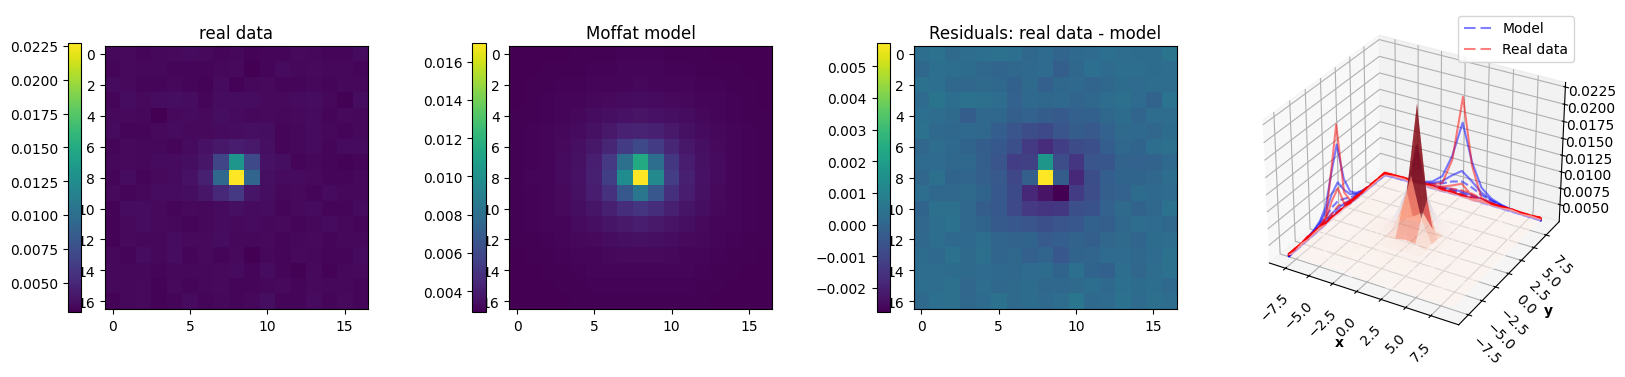

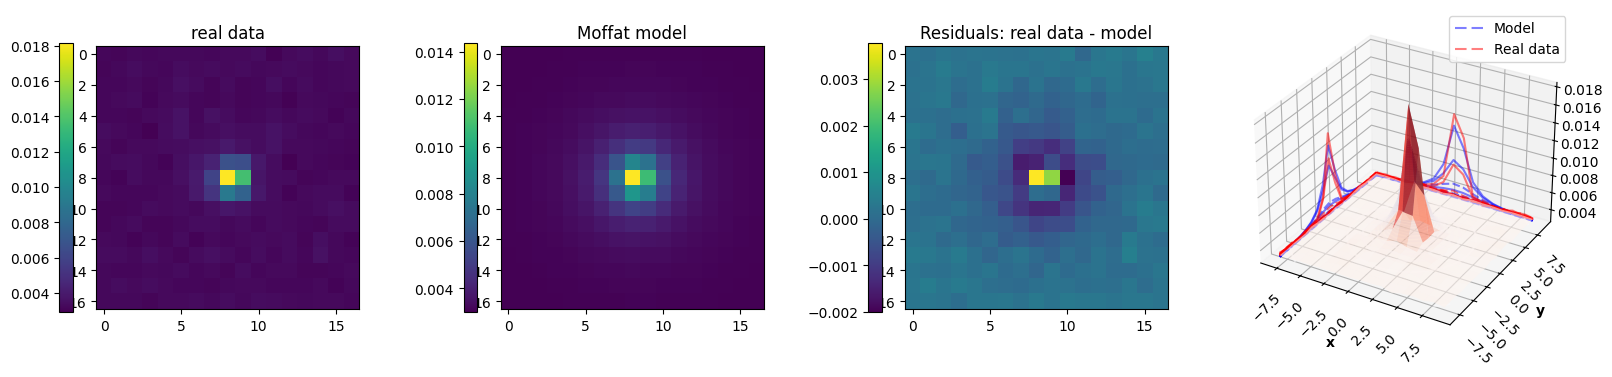

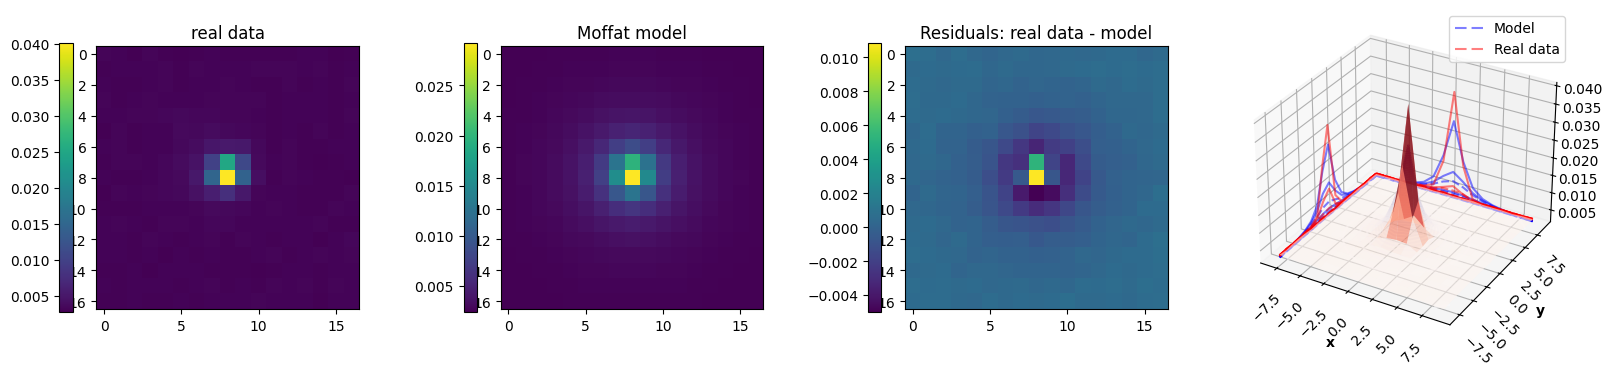

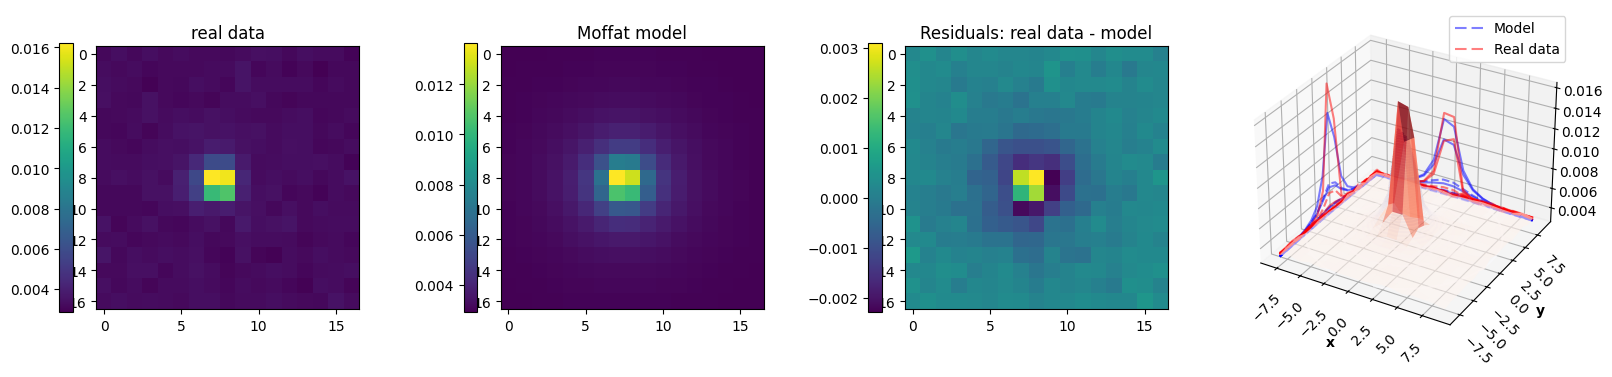

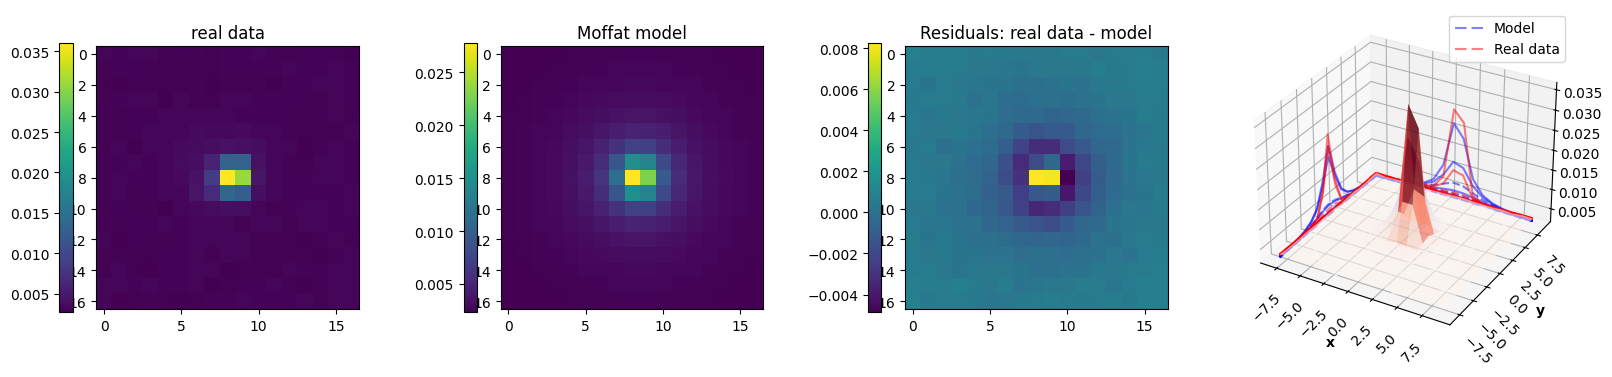

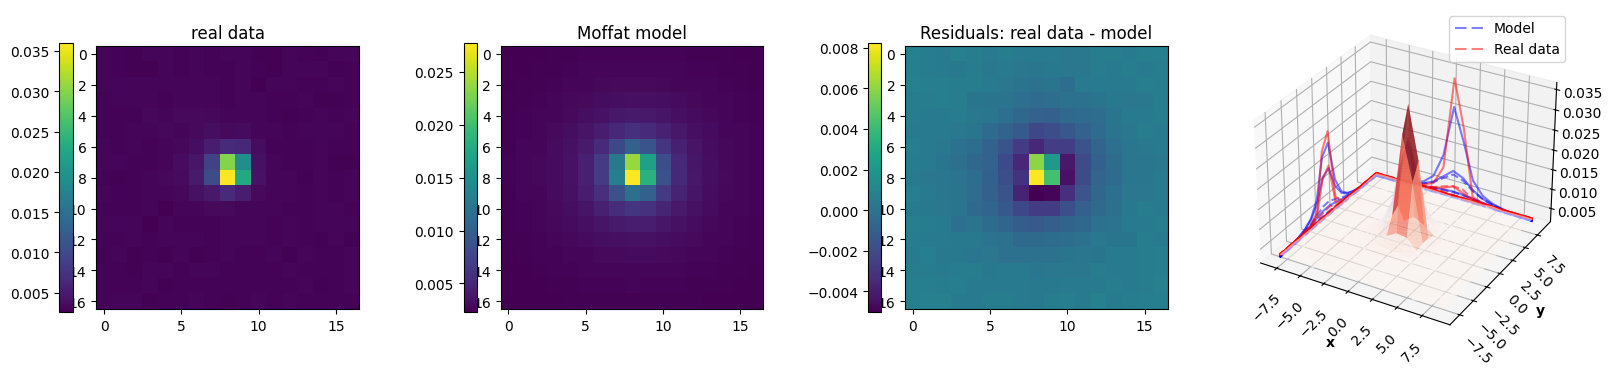

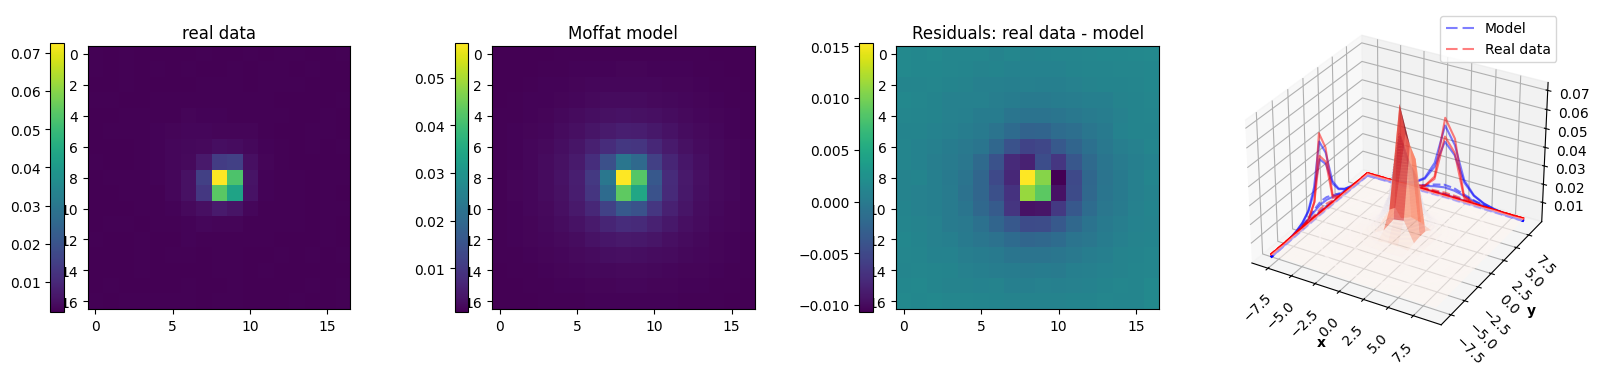

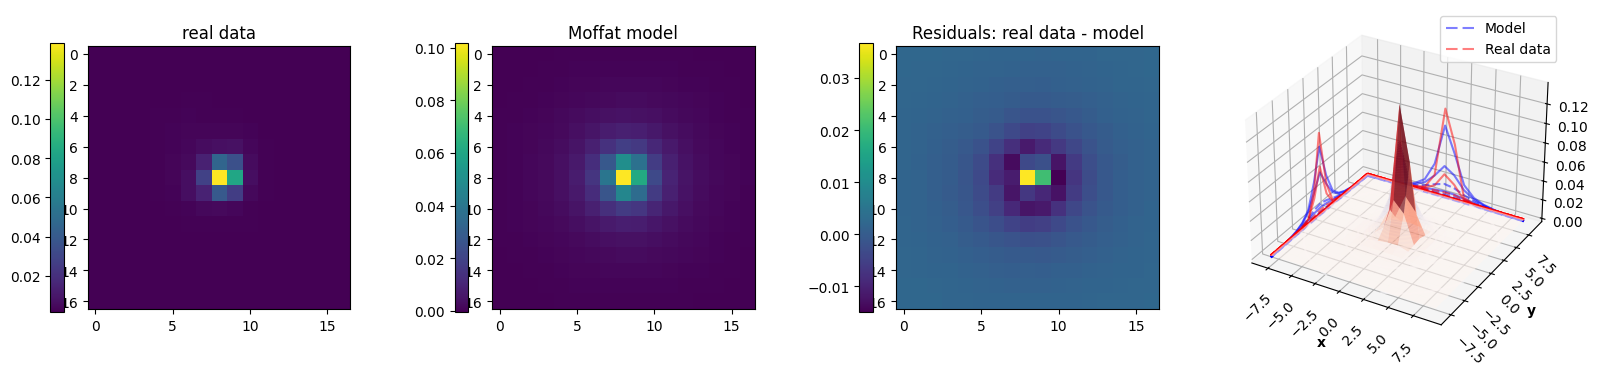

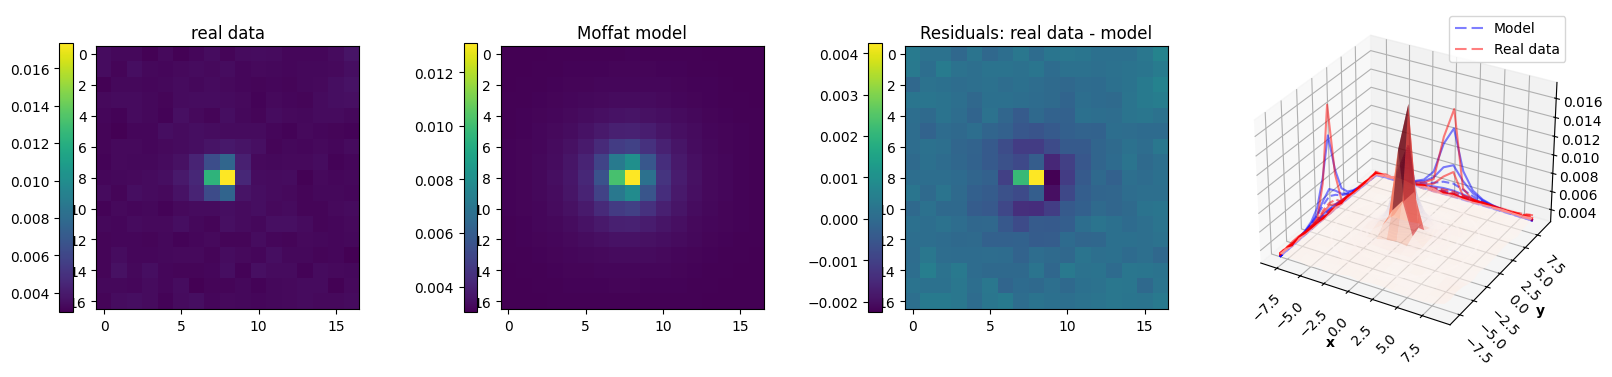

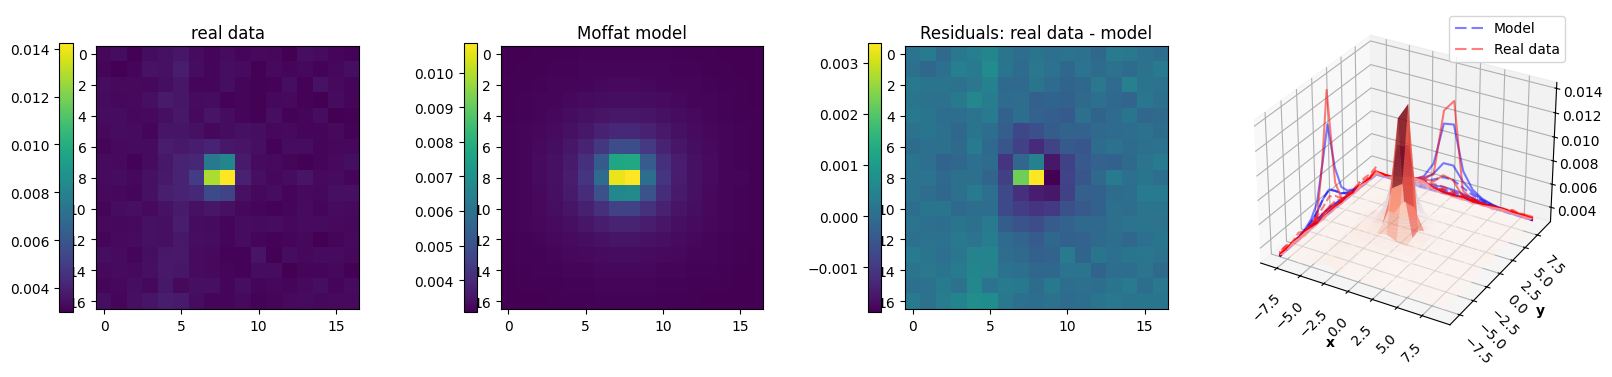

In [10]:
%%time

total_images = 10 # number of data items selected in the dataframe
end = qimg_catalog_isolated_mag_bord.head(total_images)
size = 17
params_init = (1, 0, 0, 1, 1, 0)  # initial parameters for the moffat model : A, x0, y0, gamma, alpha, b
results = end.apply(custom_function, axis=1)   